# Flower Classification

This dataset contains 4323 images of flowers.
The data collection is based on the data Flickr, Google Images, Yandex Images.
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions.\
The **aim of the work** is to provide a model which is able to classify the given image to its class.

## Import our data

In [ ]:
!pip install PyDrive &> /dev/null

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1cDrRvTrvw_qXGD68I3b3TGTDwSXEcRP1"})  
downloaded.GetContentFile('flowers-recognition.zip') 

In [ ]:
!unzip flowers-recognition.zip -d Flowers &> /dev/null

## Process the data

In [ ]:
# Imports
import torch
import torchvision
from matplotlib import pyplot as plt

from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
from random import shuffle
import numpy as np
from PIL import Image
%matplotlib inline

In [ ]:
data_dir ="/content/Flowers"
from torchvision import transforms

In [ ]:
transformer = torchvision.transforms.Compose(
    [   torchvision.transforms.Resize((64, 64)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomRotation(50),             
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
     
     
    ]
)
database = ImageFolder(data_dir, transform=transformer)

The 5 classes to which the images belong are: 'Daisy', 'Dandelion', 'Rose, 'Sunflworer' and 'Tulip'.

In [ ]:
database.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

To each of the label, I assigned a number to performe the classification.

In [ ]:
flower_label = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

In [ ]:
def show_sample(image, label,invert=True):
    print("Label :" +database.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label :daisy(0)


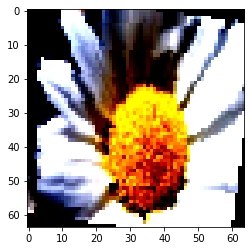

In [ ]:
show_sample(*database[1])

In [ ]:
len(database)

4323

In [ ]:
from torch.utils.data import random_split

In [ ]:
val_size = 900
test_size = 900
train_size = len(database) - val_size - test_size

train_ds, val_ds, test_ds = random_split(database, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(11))
len(train_ds), len(val_ds), len(test_ds)

(2523, 900, 900)

With the function random_split, I split the data randomly. The length of train_ds is 2523, while val_ds and test_ds is 900.

In [ ]:
batch_size=32

In [ ]:
# Define loaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size, num_workers=2, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size, num_workers=2, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size, num_workers=2, shuffle=False)

In [ ]:
from torchvision.utils import make_grid

In [ ]:
def show_batch(dl,invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


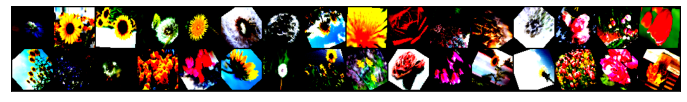

In [ ]:
show_batch(train_loader,invert=True)

## Creating a CNN Model

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()        

In [ ]:
device = get_default_device()
device

device(type='cuda')

### Model - 2 Convolutional and 3 Dense layers

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
         # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [ ]:
# Create the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [ ]:
# Get an element from the dataset
test_x, _ = train_ds[0]
# Get the size of a sample
test_x.size()

torch.Size([3, 64, 64])

In [ ]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 64, 64])

In [ ]:
output = model(test_x)
output.shape

torch.Size([1, 128, 31, 31])

In [ ]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

123008


In [ ]:
class CNN(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
         # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        #First FC layer
        nn.Linear(123008, 1024),
        nn.ReLU(),
        # Second Layer
        nn.Linear(1024, 512),
        nn.ReLU(),
        #Classification Layer
        nn.Linear(512, 5)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) 
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [ ]:
# Create the model
model = CNN()
output = model(test_x)
output.shape

torch.Size([1, 5])

In [ ]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

#### Train

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=10, dev=device):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=123008, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)
Epoch 1: TrL=1.4767, TrA=0.3365, VL=1.3070, VA=0.4235, TeL=1.3073, TeA=0.4106,
Epoch 2: TrL=1.2499, TrA=0.4357, VL=1.2163, VA=0.4892, TeL=1.1852, TeA=0.5119,
Epoch 3: TrL=1.1909, TrA=0.4839, VL=1.2017, VA=0.4634, TeL=1.1600, TeA=0.4978,
Epoch 4: TrL=1.1430, TrA=0.5188, VL=1.2068, VA=0.4547, TeL=1.1764, TeA=0.4978,
Epoch 5: TrL=1.1219, TrA=0.5403, VL=1.1819, VA=0.4892, TeL=1.1459, TeA=0.5075,
Epoch 6: TrL=1.0935, TrA=0.5419, VL=1.1115, VA=0

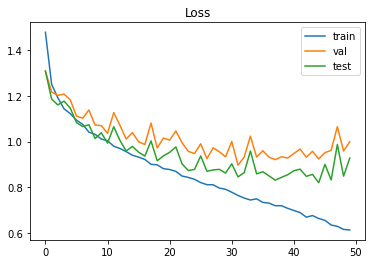

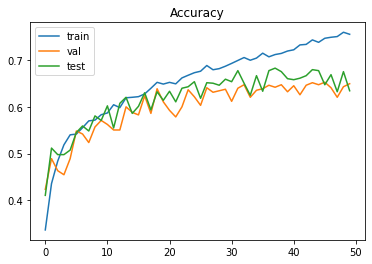

In [ ]:
# Train model
train(model, loaders, optimizer, criterion, epochs=50, dev=device)

### Model - 3 Convolutional and 3 Dense layers

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
         # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [ ]:
# Create the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [ ]:
# Get an element from the dataset
test_x, _ = train_ds[0] 
# Get the size of a sample
test_x.size()

torch.Size([3, 64, 64])

In [ ]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 64, 64])

In [ ]:
output = model(test_x)
output.shape

torch.Size([1, 256, 15, 15])

In [ ]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

57600


In [ ]:
class CNN(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
         # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # First FC layer
        nn.Linear(57600, 1024),
        nn.ReLU(),
        # Second Layer
        nn.Linear(1024, 512),
        nn.ReLU(),
        #Classification Layer
        nn.Linear(512, 5)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) 
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [ ]:
# Create the model
model2 = CNN()
output = model2(test_x)
output.shape

torch.Size([1, 5])

In [ ]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model2.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

#### Train

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=10, dev=device):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=57600, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)
Epoch 1: TrL=1.5811, TrA=0.2880, VL=1.5430, VA=0.3588, TeL=1.5428, TeA=0.3599,
Epoch 2: TrL=1.4451, TrA=0.3894, VL=1.3574, VA=0.3879, TeL=1.3265, TeA=0.4052,
Epoch 3: TrL=1.2492, TrA=0.4525, VL=1.2101, VA=0.4752, TeL=1.1690, TeA=0.4946,
Epoch 4: TrL=1.1814, TrA=0.494

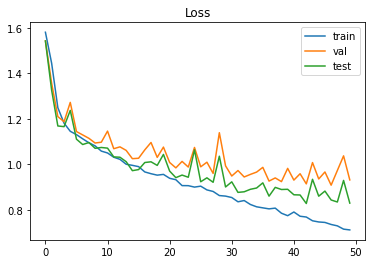

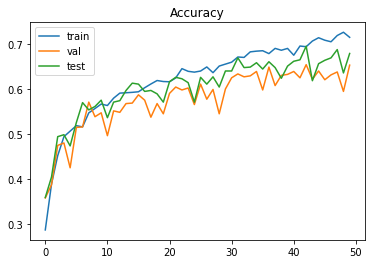

In [ ]:
# Train model
train(model2, loaders, optimizer, criterion, epochs=50, dev=device)

### Model - 4 Convolutional and 3 Dense layers

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
         # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Layer 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [ ]:
# Create the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [ ]:
# Get an element from the dataset
test_x, _ = train_ds[0]
# Get the size of a sample
test_x.size() # each element of the dataset is a couple (image, label)

torch.Size([3, 64, 64])

In [ ]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 64, 64])

In [ ]:
output = model(test_x)
output.shape

torch.Size([1, 512, 7, 7])

In [ ]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

25088


In [ ]:
class CNN(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Layer 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


        # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # First FC layer
        nn.Linear(25088, 1024),
        nn.ReLU(),
        # Second Layer
        nn.Linear(1024, 512),
        nn.ReLU(),
        #Classification Layer
        nn.Linear(512, 5)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) 
    x = x.view(x.size(0), -1)
    output = self.fc_layers(x) 
    return output

In [ ]:
# Create the model
model3 = CNN()
output = model3(test_x)
output.shape

torch.Size([1, 5])

In [ ]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model3.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

#### Train

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=10, dev=device):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)
Epoch 1: TrL=1.6052, TrA=0.2270, VL=1.6002, VA=0.2371, TeL=1.6025, TeA=0.2284,
Epoch 2: T

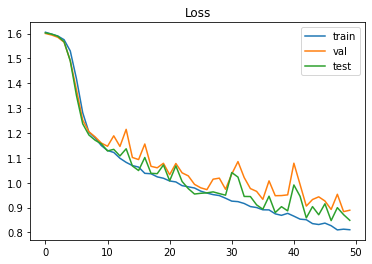

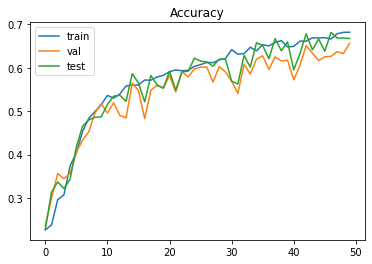

In [ ]:
# Train model
train(model3, loaders, optimizer, criterion, epochs=50, dev=device)

### Model - 5 Convolutional and 3 Dense layers

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
         # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 5
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [ ]:
# Create the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [ ]:
# Get an element from the dataset
test_x, _ = train_ds[0] 
# Get the size of a sample
test_x.size()

torch.Size([3, 64, 64])

In [ ]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 64, 64])

In [ ]:
output = model(test_x)
output.shape

torch.Size([1, 1024, 3, 3])

In [ ]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

9216


In [ ]:
class CNN(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
         # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 5
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # First FC layer
        nn.Linear(9216, 1024),
        nn.ReLU(),
        # Second Layer
        nn.Linear(1024, 512),
        nn.ReLU(),
        #Classification Layer
        nn.Linear(512, 5)
    )
  # Forward
  def forward(self, x):
    x = self.conv_layer(x) 
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [ ]:
# Create the model
model4 = CNN()
output = model4(test_x)
output.shape

torch.Size([1, 5])

In [ ]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model4.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

#### Train

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=10, dev=device):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bi

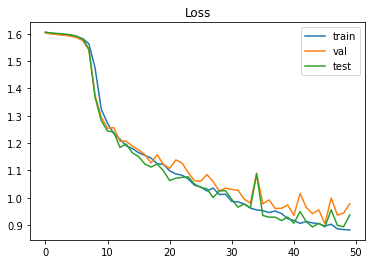

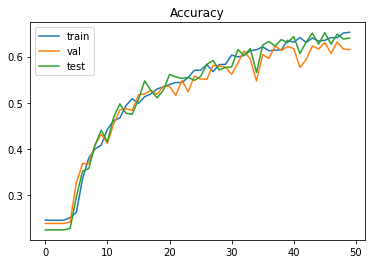

In [ ]:
# Train model
train(model4, loaders, optimizer, criterion, epochs=50, dev=device)

## Conclusion

At the end, comparing the accuracy values on the validation set, the best model result to be : Model - 3 Convolutional and 3 Dense Layers\
Here we will see an example of prediction.

In [ ]:
def predict_image(img, model):
    img = (img.unsqueeze(dim=0)).to(device)
    yb = model(img)
    _, preds  = torch.max(yb, dim=1)
    return flower_label[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: tulip , Predicted: tulip


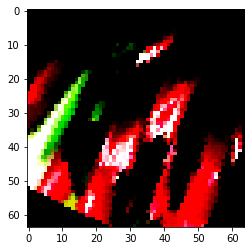

In [ ]:
img, label = test_ds[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', flower_label[label], ', Predicted:', predict_image(img, model2))